# S&P 500 Trading Algorithm

This notebook implements a trading algorithm for the S&P 500 using machine learning models. We will use available parameters as signals and build models like FFNN, LSTM, and CNN.

## Data Loading and Exploration

In [193]:
import pandas as pd
import numpy as np


# Load the CSV data
data = pd.read_csv("C:/Users/David/Documents/GitHub/Quantitative_Trading_Algorithm/output.csv")

# Print the columns to understand the data structure
print("Data Columns:")
print(data.columns)

# Based on the legend, we should map these columns to lowercase
selected_columns = [
    'emp', 'pe', 'cape', 'dy', 'rho', 'day', 'month', 'year',
    'mov', 'ir', 'rr',
    'y02', 'y10', 'stp', 'cf', 'mg', 'rv', 'ed', 'un',
    'gdp', 'm2', 'cpi', 'dil', 'yss', 'nyf',
    '_au', '_dxy', '_lcp', '_ty', '_oil',
    '_mkt', '_va', '_gr'
]

# Check if the selected columns are in the data
available_columns = [col for col in selected_columns if col in data.columns]
print("Selected Available Columns:")
print(available_columns)

# Extracting the relevant columns
data = data[available_columns + ['snp']]  # Including 'snp' as target

Data Columns:
Index(['emp', 'pe', 'cape', 'dy', 'rho', 'mov', 'ir', 'rr', 'y02', 'y10',
       'stp', 'cf', 'mg', 'rv', 'ed', 'un', 'gdp', 'm2', 'cpi', 'dil', 'yss',
       'nyf', '_au', '_dxy', '_lcp', '_ty', '_oil', '_mkt', '_va', '_gr',
       'snp', 'date', 'year', 'month', 'day', 'label'],
      dtype='object')
Selected Available Columns:
['emp', 'pe', 'cape', 'dy', 'rho', 'day', 'month', 'year', 'mov', 'ir', 'rr', 'y02', 'y10', 'stp', 'cf', 'mg', 'rv', 'ed', 'un', 'gdp', 'm2', 'cpi', 'dil', 'yss', 'nyf', '_au', '_dxy', '_lcp', '_ty', '_oil', '_mkt', '_va', '_gr']


## Preprocess and Feature Engineering

In [194]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Handle missing values
data = data.dropna()

# Extract features and target
features = data.drop(columns=['snp'])
target = data['snp']

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

print("Feature Engineering and Data Preprocessing Complete.")


Feature Engineering and Data Preprocessing Complete.


## Custom Train-Test Split for LSTM To Keep Data Sequential

In [195]:
import numpy as np

# Custom function to split data for each year to keep the data sequential and preserve indices
def custom_train_test_split_with_indices(features, target, train_size=42, test_size=10):
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []
    train_indices, test_indices = [], []

    for start in range(0, len(features), train_size + test_size):
        end_train = start + train_size
        end_test = end_train + test_size
        if end_test <= len(features):
            X_train_list.append(features[start:end_train])
            y_train_list.append(target[start:end_train])
            X_test_list.append(features[end_train:end_test])
            y_test_list.append(target[end_train:end_test])
            train_indices.extend(range(start, end_train))
            test_indices.extend(range(end_train, end_test))
    
    X_train_lstm_prepared = np.concatenate(X_train_list)
    y_train_lstm_prepared = np.concatenate(y_train_list)
    X_test_lstm_prepared = np.concatenate(X_test_list)
    y_test_lstm_prepared = np.concatenate(y_test_list)
    
    return (X_train_lstm_prepared, y_train_lstm_prepared, train_indices,
            X_test_lstm_prepared, y_test_lstm_prepared, test_indices)

# Split the data using the custom function
X_train_lstm_prepared, y_train_lstm_prepared, train_indices, X_test_lstm_prepared, y_test_lstm_prepared, test_indices = custom_train_test_split_with_indices(features_scaled, target)

# Reshape data for LSTM (needs 3D input: [samples, time steps, features])
X_train_lstm = X_train_lstm_prepared.reshape((X_train_lstm_prepared.shape[0], 1, X_train_lstm_prepared.shape[1]))
X_test_lstm = X_test_lstm_prepared.reshape((X_test_lstm_prepared.shape[0], 1, X_test_lstm_prepared.shape[1]))



In [196]:
y_test_lstm_prepared

array([ 290.28875351,  295.4912529 ,  295.4912529 ,  294.52500153,
        294.52500153,  290.82375336,  290.82375336,  295.99000168,
        291.67375183,  295.49875259,  339.8975029 ,  328.42374802,
        328.42374802,  334.54873657,  334.54873657,  332.1625061 ,
        332.1625061 ,  340.01750183,  344.14375305,  341.53624725,
        333.71250153,  350.14374542,  350.14374542,  365.51249695,
        365.51249695,  369.07500076,  377.05250549,  374.66374969,
        373.95874023,  374.84624863,  418.48622894,  418.69124603,
        412.24000168,  412.75374985,  412.75374985,  414.85499191,
        414.85499191,  414.85499191,  407.94375229,  413.78875732,
        437.47249985,  439.85124588,  439.85124588,  439.85124588,
        439.85124588,  442.69499207,  442.69499207,  442.69499207,
        451.37123489,  449.29875183,  474.31249619,  476.90500259,
        485.51625824,  485.51625824,  471.98873901,  471.98873901,
        467.22626114,  467.22626114,  468.17500305,  474.48375

## Model Implementation

### Feed-Forward Neural Network (FFNN)

Epoch 1/50


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3554962.0000 - val_loss: 3810307.7500
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3616737.0000 - val_loss: 3435656.5000
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3375081.2500 - val_loss: 2370928.2500
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1943476.8750 - val_loss: 956078.5000
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 818801.9375 - val_loss: 291138.8750
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 326241.6250 - val_loss: 171332.0781
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 247858.5156 - val_loss: 127027.9375
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 226065.7344 - val_loss: 100868.6328
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 183574.4688 - val_loss: 82007.0391
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131047.3125 - val_loss: 69044.1094
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 143162

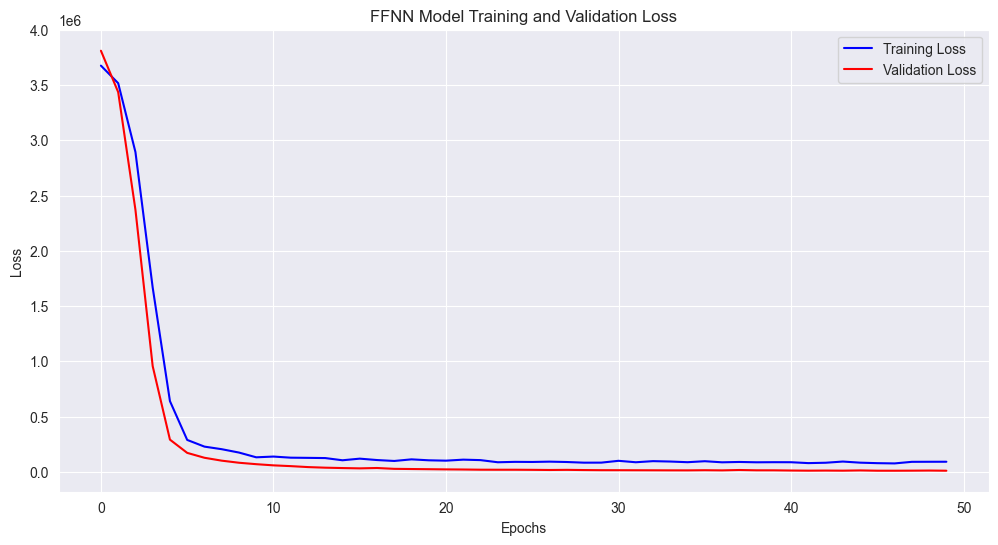

In [197]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define the FFNN model creation function
def create_ffnn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Training with all parameters
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

ffnn_model = create_ffnn_model(X_train_scaled.shape[1])
ffnn_history = ffnn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

ffnn_evaluation = ffnn_model.evaluate(X_test_scaled, y_test)
print(f"FFNN Model Test Loss: {ffnn_evaluation}")

ffnn_predictions = ffnn_model.predict(X_test_scaled)
print("FFNN Model Training and Evaluation Complete.")

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(ffnn_history.history['loss'], label='Training Loss', color='blue')
plt.plot(ffnn_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('FFNN Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Long Short-Term Memory Network (LSTM)

Epoch 1/40


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1404547.2500 - val_loss: 12303238.0000
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1415125.7500 - val_loss: 12299031.0000
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1396647.5000 - val_loss: 12289412.0000
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1345196.8750 - val_loss: 12269354.0000
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1358254.5000 - val_loss: 12231695.0000
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1353381.2500 - val_loss: 12166509.0000
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1335093.6250 - val_loss: 12064816.0000
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1329487.1250 - val_loss: 11930661.0000
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1313864.8750 - val_loss: 11741343.0000
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1315037.1250 - val_loss: 11513067.0000
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0

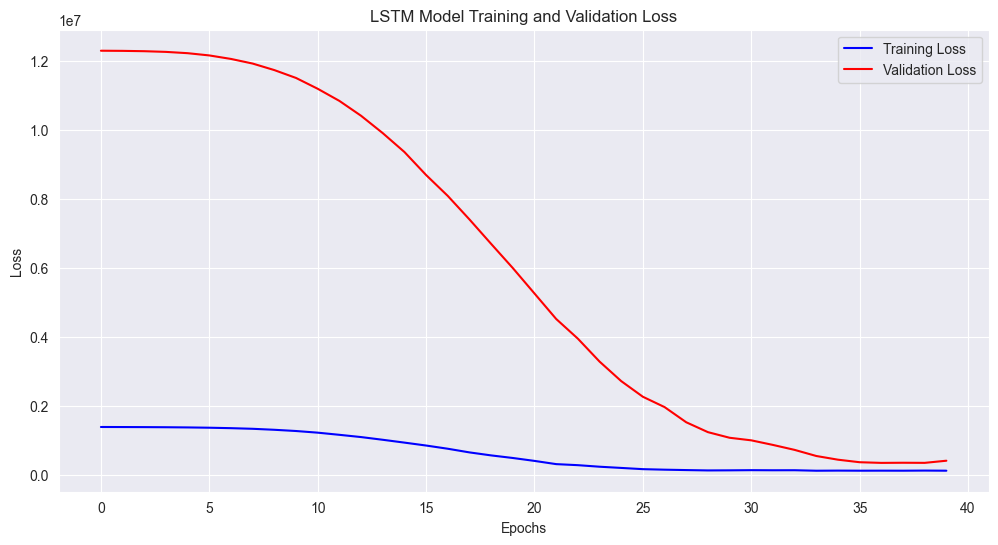

In [198]:
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Define the LSTM model creation function
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(10, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))  # Add dropout for regularization
    model.add(BatchNormalization())  # Add batch normalization
    model.add(Dense(32, activation='relu'))  # Add an additional dense layer
    model.add(Dropout(0.5))  # Add another dropout for regularization
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Training with all parameters
lstm_model = create_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_history = lstm_model.fit(X_train_lstm, y_train_lstm_prepared, epochs=40, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])

lstm_evaluation = lstm_model.evaluate(X_test_lstm, y_test_lstm_prepared)
print(f"LSTM Model Test Loss: {lstm_evaluation}")

lstm_predictions = lstm_model.predict(X_test_lstm)
print("LSTM Model Training and Evaluation Complete.")

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss', color='blue')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('LSTM Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Convolutional Neural Network (CNN)

Epoch 1/40


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3391335.0000 - val_loss: 1082910.1250
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1061403.0000 - val_loss: 854175.5000
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 729177.7500 - val_loss: 436882.7188
Epoch 4/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 352286.0000 - val_loss: 147978.7656
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 144536.4062 - val_loss: 92888.8125
Epoch 6/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 94319.7969 - val_loss: 62503.1250
Epoch 7/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 69057.9688 - val_loss: 46579.5273
Epoch 8/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 48474.3906 - val_loss: 36302.1484
Epoch 9/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 39950.1641 - val_loss: 30062.5059
Epoch 10/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 33065.7617 - val_loss: 24696.8359
Epoch 11/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28641.2910 - val_lo

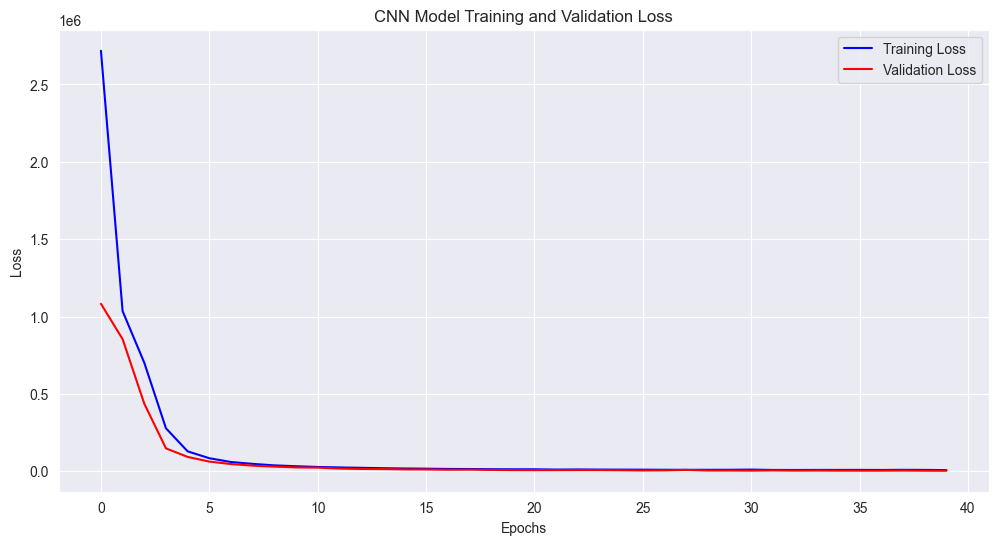

In [199]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

# Define the CNN model creation function
def create_cnn_model(input_dim):
    model = Sequential()
    model.add(Reshape((input_dim, 1), input_shape=(input_dim,)))
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.25))  # Dropout layer to reduce overfitting
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Training with all parameters
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_model = create_cnn_model(X_train_scaled.shape[1])
cnn_history = cnn_model.fit(X_train_scaled, y_train, epochs=40, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

cnn_evaluation = cnn_model.evaluate(X_test_scaled, y_test)
print(f"CNN Model Test Loss: {cnn_evaluation}")

cnn_predictions = cnn_model.predict(X_test_scaled)
print("CNN Model Training and Evaluation Complete.")

plt.figure(figsize=(12, 6))
plt.plot(cnn_history.history['loss'], label='Training Loss', color='blue')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('CNN Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#
From here trash code

Dave Evaluation of Strategy:
- [ ] Sharpe Ratio -> Verschoben auf nach Strategie Implementation
- [x] In sample, out sample performance
- [x] Information Coefficient


Rafael
- [ ] Use Multiple Sets of Signals

Felix
- [ ] Write shit
- [ ] Hyperparameter Tuning (Optional)

After:
- [ ] Hyperparameter Tuning
- [ ] Data Augmentation


## Backtest and Evaluate the Models

Get the in-sample and out-of-sample R-Squared and MSE
The Information Coefficient (IC) measures the correlation between predicted and actual returns.
see: https://www.investopedia.com/terms/i/information-coefficient.asp


In [200]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

def calculate_proportion_correct(predictions, actuals):
    predictions = predictions.flatten()
    actuals = actuals
    min_length = min(len(predictions), len(actuals))
    predictions = predictions[:min_length]
    actuals = actuals[:min_length]
    actual_directions = np.diff(actuals) > 0
    predicted_directions = np.diff(predictions) > 0
    correct_predictions = np.where(predicted_directions == actual_directions, 1, 0)
    proportion_correct = np.mean(correct_predictions)
    return proportion_correct

def calculate_ic(proportion_correct):
    # The Information Coefficient (IC) is a measure of the correlation between predicted and actual returns.
    return (2 * proportion_correct) - 1


# In-sample predictions
ffnn_train_predictions = ffnn_model.predict(X_train)
lstm_train_predictions = lstm_model.predict(X_train_lstm)
cnn_train_predictions = cnn_model.predict(X_train)

# Ensure lengths are consistent
min_length_ffnn = min(len(y_test), len(ffnn_predictions))
y_test_ffnn = y_test[:min_length_ffnn]
ffnn_predictions = ffnn_predictions[:min_length_ffnn]

min_length_lstm = min(len(y_test_lstm_prepared), len(lstm_predictions))
y_test_lstm = y_test_lstm_prepared[:min_length_lstm]
lstm_predictions = lstm_predictions[:min_length_lstm]

min_length_cnn = min(len(y_test), len(cnn_predictions))
y_test_cnn = y_test[:min_length_cnn]
cnn_predictions = cnn_predictions[:min_length_cnn]

# FFNN performance
ffnn_in_sample_r2 = r2_score(y_train, ffnn_train_predictions)
ffnn_out_sample_r2 = r2_score(y_test_ffnn, ffnn_predictions)
ffnn_in_sample_mse = mean_squared_error(y_train, ffnn_train_predictions)
ffnn_out_sample_mse = mean_squared_error(y_test_ffnn, ffnn_predictions)

# LSTM performance
lstm_in_sample_r2 = r2_score(y_train_lstm_prepared, lstm_train_predictions)
lstm_out_sample_r2 = r2_score(y_test_lstm, lstm_predictions)
lstm_in_sample_mse = mean_squared_error(y_train_lstm_prepared, lstm_train_predictions)
lstm_out_sample_mse = mean_squared_error(y_test_lstm, lstm_predictions)

# CNN performance
cnn_in_sample_r2 = r2_score(y_train, cnn_train_predictions)
cnn_out_sample_r2 = r2_score(y_test_cnn, cnn_predictions)
cnn_in_sample_mse = mean_squared_error(y_train, cnn_train_predictions)
cnn_out_sample_mse = mean_squared_error(y_test_cnn, cnn_predictions)


ffnn_proportion_correct = calculate_proportion_correct(ffnn_predictions, y_test_ffnn)
ffnn_ic_new = calculate_ic(ffnn_proportion_correct)

lstm_proportion_correct = calculate_proportion_correct(lstm_predictions, y_test_lstm)
lstm_ic_new = calculate_ic(lstm_proportion_correct)

cnn_proportion_correct = calculate_proportion_correct(cnn_predictions, y_test_cnn)
cnn_ic_new = calculate_ic(cnn_proportion_correct)

# Create a table for all metrics
metrics_data = {
    "Model": ["FFNN", "LSTM", "CNN"],
    "In-sample MSE": [ffnn_in_sample_mse, lstm_in_sample_mse, cnn_in_sample_mse],
    "Out-sample MSE": [ffnn_out_sample_mse, lstm_out_sample_mse, cnn_out_sample_mse],
    "In-sample R2": [ffnn_in_sample_r2, lstm_in_sample_r2, cnn_in_sample_r2],
    "Out-sample R2": [ffnn_out_sample_r2, lstm_out_sample_r2, cnn_out_sample_r2],
    "In-sample IC": [ffnn_ic_new, lstm_ic_new, cnn_ic_new],
    "Out-sample IC": [ffnn_ic_new, lstm_ic_new, cnn_ic_new]
}

metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Model,In-sample MSE,Out-sample MSE,In-sample R2,Out-sample R2,In-sample IC,Out-sample IC
0,FFNN,1.117528e+04,12837.217684,0.991398,0.991338,0.914894,0.914894
1,LSTM,1.006846e+05,70575.495275,0.917923,0.950765,0.136490,0.136490
2,CNN,5.513752e+06,6495.243867,-3.244263,0.995617,0.925532,0.925532


Sharpe Ratio Calculation:
Still To Do


### Show and Discuss Results
We will create charts to visualize the actual vs. predicted values for each model and discuss the results.

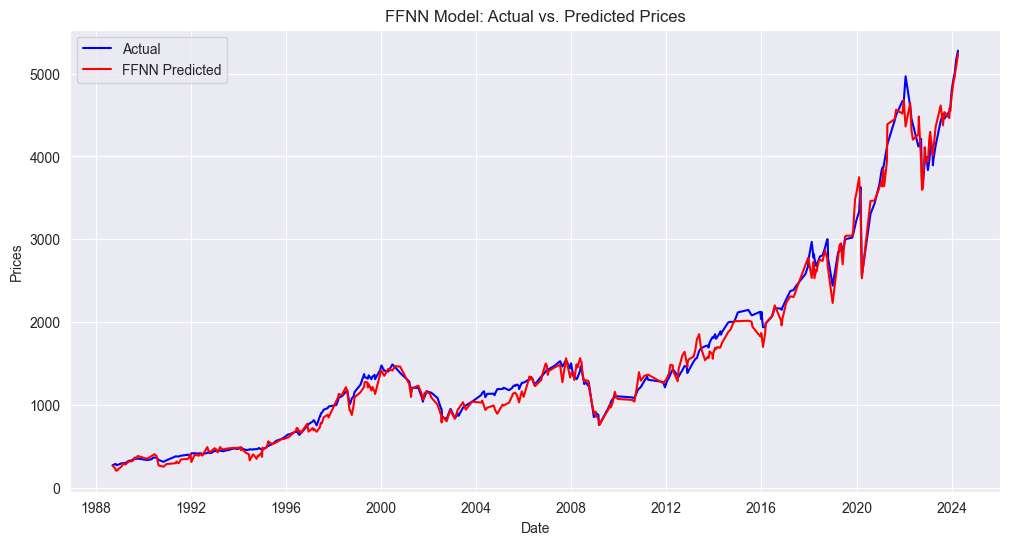

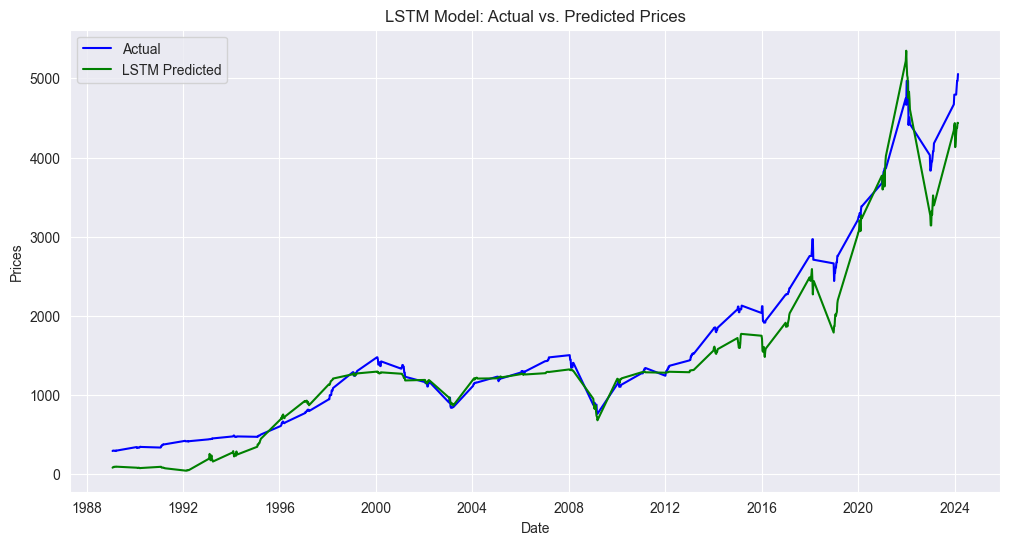

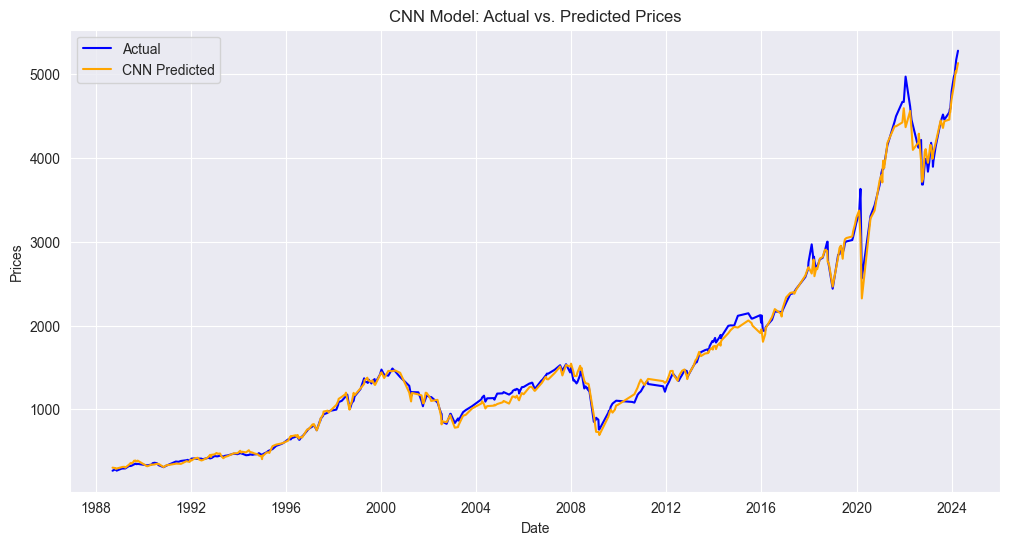

In [201]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the original dataset is named `data` and has columns 'day', 'month', 'year', and 'Target'
# Also assuming y_test, y_test_lstm_prepared, ffnn_predictions, lstm_predictions, cnn_predictions are defined

# Step 1: Create a Date column from 'day', 'month', and 'year'
data['Date'] = pd.to_datetime(data[['year', 'month', 'day']])

# Ensure all predictions and actuals are 1-dimensional
y_test_series = pd.Series(y_test.squeeze(), index=y_test.index, name='Actual')
y_test_lstm_series = pd.Series(y_test_lstm_prepared.squeeze(), index=y_test_lstm_prepared, name='Actual')
ffnn_predictions_flat = ffnn_predictions.flatten()
lstm_predictions_flat = lstm_predictions.flatten()
cnn_predictions_flat = cnn_predictions.flatten()

# Create DataFrame for y_test and ffnn_predictions
ffnn_test_df = pd.DataFrame({
    'Actual': y_test_series.values,
    'FFNN_Predicted': ffnn_predictions_flat
}, index=y_test_series.index)

# Merge ffnn_test_df with the original data using the index
ffnn_merged_df = data.join(ffnn_test_df, how='inner')

# Plot actual vs. predicted values for FFNN
plt.figure(figsize=(12, 6))
plt.plot(ffnn_merged_df['Date'], ffnn_merged_df['Actual'], label='Actual', color='blue')
plt.plot(ffnn_merged_df['Date'], ffnn_merged_df['FFNN_Predicted'], label='FFNN Predicted', color='red')
plt.title('FFNN Model: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()
lstm_test_df = pd.DataFrame({
    'Date_lstm': data.loc[test_indices, 'Date'].values,
    'Actual_lstm': y_test_lstm_prepared,
    'LSTM_Predicted': lstm_predictions.flatten()
}, index=test_indices)

# Verify that the DataFrame has the correct length and indices

# Merge lstm_test_df with the original data using the index
lstm_merged_df = data.join(lstm_test_df, how='inner', lsuffix='_orig', rsuffix='_lstm')

# Verify the merged DataFrame

# Plot actual vs. predicted values for LSTM
plt.figure(figsize=(12, 6))
plt.plot(lstm_merged_df['Date_lstm'], lstm_merged_df['Actual_lstm'], label='Actual', color='blue')
plt.plot(lstm_merged_df['Date_lstm'], lstm_merged_df['LSTM_Predicted'], label='LSTM Predicted', color='green')
plt.title('LSTM Model: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

# Flatten the CNN predictions and create a DataFrame with the actual values and corresponding dates
cnn_test_df = pd.DataFrame({
    'Date_cnn': data.loc[y_test.index, 'Date'].values,
    'Actual_cnn': y_test.values,
    'CNN_Predicted': cnn_predictions.flatten()
}, index=y_test.index)

# Verify that the DataFrame has the correct length and indices

# Merge cnn_test_df with the original data using the index
cnn_merged_df = data.join(cnn_test_df, how='inner', lsuffix='_orig', rsuffix='_cnn')

# Verify the merged DataFrame

# Plot actual vs. predicted values for CNN
plt.figure(figsize=(12, 6))
plt.plot(cnn_merged_df['Date_cnn'], cnn_merged_df['Actual_cnn'], label='Actual', color='blue')
plt.plot(cnn_merged_df['Date_cnn'], cnn_merged_df['CNN_Predicted'], label='CNN Predicted', color='orange')
plt.title('CNN Model: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

Interpretation of Results:
The charts show the actual vs. predicted values for each model (FFNN, LSTM, CNN). The models' predictions are compared to the actual S&P 500 index values. The visualizations help understand the models' performance in predicting the stock market movements. The LSTM plot look a bit strange due to unique train test split we implemented to keep the data sequential.

# Use Multiple Sets of Signals
We will evaluate the models using two sets of signals:

Set 1: Macroeconomic Signals:

GDP: Gross Domestic Product growth.
CPI: Inflation rate.
UN: Unemployment rate.
IR: Nominal interest rate.
Y10: 10Y treasury yield.
Economic Motivation: These indicators are fundamental to the overall economic environment and can significantly influence stock market movements. Changes in GDP, inflation, and interest rates are closely monitored by investors.

Set 2: Market and Technical Signals:

PE: Price/Earnings ratio.
DY: Dividend yield.
_MKT: Market returns.
_VA: Value index.
_GR: Growth index.
Economic Motivation: These indicators provide insight into market valuation and performance. They help understand the relative attractiveness of stocks and the broader market trends.

We will re-train and evaluate the models using these sets of signals.

## FFNN

In [202]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10']

# Filter data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

X_train_macro, X_test_macro, y_train_macro, y_test_macro = train_test_split(features_macro_scaled, target_macro, test_size=0.3, random_state=42)

ffnn_model_macro = create_ffnn_model(X_train_macro.shape[1])
ffnn_history_macro = ffnn_model_macro.fit(X_train_macro, y_train_macro, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

ffnn_evaluation_macro = ffnn_model_macro.evaluate(X_test_macro, y_test_macro)
print(f"FFNN Model with Macro Signals Test Loss: {ffnn_evaluation_macro}")

ffnn_macro_predictions = ffnn_model_macro.predict(X_test_macro)


# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr']

# Filter data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(features_market_scaled, target_market, test_size=0.3, random_state=42)

ffnn_model_market = create_ffnn_model(X_train_market.shape[1])
ffnn_history_market = ffnn_model_market.fit(X_train_market, y_train_market, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

ffnn_evaluation_market = ffnn_model_market.evaluate(X_test_market, y_test_market)
print(f"FFNN Model with Market Signals Test Loss: {ffnn_evaluation_market}")

ffnn_market_predictions = ffnn_model_market.predict(X_test_market)



Epoch 1/40


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3987581.7500 - val_loss: 3819990.5000
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3519470.0000 - val_loss: 3751207.7500
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3371720.2500 - val_loss: 3534346.7500
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3262121.2500 - val_loss: 3116384.2500
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2830261.7500 - val_loss: 2566107.5000
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2322347.7500 - val_loss: 2065719.7500
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1856942.5000 - val_loss: 1767643.5000
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1709966.7500 - val_loss: 1619661.0000
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1767222.1250 - val_loss: 1546161.2500
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1589832.2500 - val_loss: 1483367.5000
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4116812.5000 - val_loss: 3814981.2500
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3659557.5000 - val_loss: 3728720.7500
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3488840.7500 - val_loss: 3468855.5000
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3494772.7500 - val_loss: 2973050.7500
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2771434.2500 - val_loss: 2256161.7500
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2200174.2500 - val_loss: 1512019.6250
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1287703.5000 - val_loss: 920213.5000
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 863446.4375 - val_loss: 583534.6875
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 648081.0000 - val_loss: 433925.7812
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 526264.5625 - val_loss: 357431.7500
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss

# LSTM

In [203]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10']

# Filter and reshape data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

# Split the data using the custom function
X_train_macro_prepared, y_train_macro_prepared, X_test_macro_prepared, y_test_macro_prepared = custom_train_test_split(features_macro_scaled, target_macro)

# Reshape data for LSTM (needs 3D input)
X_train_macro_lstm = X_train_macro_prepared.reshape((X_train_macro_prepared.shape[0], 1, X_train_macro_prepared.shape[1]))
X_test_macro_lstm = X_test_macro_prepared.reshape((X_test_macro_prepared.shape[0], 1, X_test_macro_prepared.shape[1]))

lstm_model_macro = create_lstm_model((X_train_macro_lstm.shape[1], X_train_macro_lstm.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Increased patience
lstm_history_macro = lstm_model_macro.fit(X_train_macro_lstm, y_train_macro_prepared, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])  # Increased epochs

lstm_evaluation_macro = lstm_model_macro.evaluate(X_test_macro_lstm, y_test_macro_prepared)
print(f"LSTM Model with Macro Signals Test Loss: {lstm_evaluation_macro}")

lstm_macro_predictions = lstm_model_macro.predict(X_test_macro_lstm)


# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr']

# Filter and reshape data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

# Split the data using the custom function
X_train_market_prepared, y_train_market_prepared, X_test_market_prepared, y_test_market_prepared = custom_train_test_split(features_market_scaled, target_market)

# Reshape data for LSTM (needs 3D input)
X_train_market_lstm = X_train_market_prepared.reshape((X_train_market_prepared.shape[0], 1, X_train_market_prepared.shape[1]))
X_test_market_lstm = X_test_market_prepared.reshape((X_test_market_prepared.shape[0], 1, X_test_market_prepared.shape[1]))

lstm_model_market = create_lstm_model((X_train_market_lstm.shape[1], X_train_market_lstm.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Increased patience
lstm_history_market = lstm_model_market.fit(X_train_market_lstm, y_train_market_prepared, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])  # Increased epochs

lstm_evaluation_market = lstm_model_market.evaluate(X_test_market_lstm, y_test_market_prepared)
print(f"LSTM Model with Market Signals Test Loss: {lstm_evaluation_market}")

lstm_market_predictions = lstm_model_market.predict(X_test_market_lstm)
lstm_market_mse = mean_squared_error(y_test_market_prepared, lstm_market_predictions)
lstm_market_r2 = r2_score(y_test_market_prepared, lstm_market_predictions)


Epoch 1/100


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1344976.1250 - val_loss: 12303117.0000
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1388760.3750 - val_loss: 12299288.0000
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1399551.6250 - val_loss: 12291836.0000
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1367279.3750 - val_loss: 12278148.0000
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1350273.7500 - val_loss: 12252689.0000
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1401870.2500 - val_loss: 12209838.0000
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1331683.3750 - val_loss: 12146838.0000
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1326585.3750 - val_loss: 12051085.0000
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1286813.8750 - val_loss: 11916961.0000
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1238226.3750 - val_loss: 11731932.0000
Epoch 11/100
38/38 ━━━━━━━━━━━━

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1407447.5000 - val_loss: 12303579.0000
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1387765.3750 - val_loss: 12300369.0000
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1401499.0000 - val_loss: 12293515.0000
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1343114.2500 - val_loss: 12279376.0000
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1381791.3750 - val_loss: 12251809.0000
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1365215.3750 - val_loss: 12201847.0000
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1328292.8750 - val_loss: 12115641.0000
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1362076.0000 - val_loss: 11975162.0000
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1214583.0000 - val_loss: 11766274.0000
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1250172.3750 - val_loss: 11464013.0000
Epoch 11/100
38/38 ━━━━━━━━━━━━

# CNN

In [204]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10']

# Filter data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

X_train_macro, X_test_macro, y_train_macro, y_test_macro = train_test_split(features_macro_scaled, target_macro, test_size=0.3, random_state=42)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_model_macro = create_cnn_model(X_train_macro.shape[1])
cnn_history_macro = cnn_model_macro.fit(X_train_macro, y_train_macro, epochs=40, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

cnn_evaluation_macro = cnn_model_macro.evaluate(X_test_macro, y_test_macro)
print(f"CNN Model with Macro Signals Test Loss: {cnn_evaluation_macro}")

cnn_macro_predictions = cnn_model_macro.predict(X_test_macro)


# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr']

# Filter data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(features_market_scaled, target_market, test_size=0.3, random_state=42)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_model_market = create_cnn_model(X_train_market.shape[1])
cnn_history_market = cnn_model_market.fit(X_train_market, y_train_market, epochs=40, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

cnn_evaluation_market = cnn_model_market.evaluate(X_test_market, y_test_market)
print(f"CNN Model with Market Signals Test Loss: {cnn_evaluation_market}")

cnn_market_predictions = cnn_model_market.predict(X_test_market)


Epoch 1/40


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3756528.7500 - val_loss: 3441878.0000
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2668536.2500 - val_loss: 1415602.3750
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1488564.1250 - val_loss: 1347049.0000
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1410398.0000 - val_loss: 1297638.2500
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1370425.2500 - val_loss: 1272802.0000
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1372395.8750 - val_loss: 1241377.6250
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1520361.0000 - val_loss: 1239783.2500
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1264108.8750 - val_loss: 1193822.8750
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1310925.6250 - val_loss: 1180547.6250
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1274356.1250 - val_loss: 1156238.3750
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3758311.0000 - val_loss: 3521628.0000
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2715492.2500 - val_loss: 668492.6250
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 708452.9375 - val_loss: 488012.5625
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 526044.0625 - val_loss: 298170.9688
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 286513.1875 - val_loss: 125014.7578
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 109503.8984 - val_loss: 39325.9375
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40532.5391 - val_loss: 22513.8145
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32148.0742 - val_loss: 20215.4746
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26006.2656 - val_loss: 17102.4980
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19967.8516 - val_loss: 15620.6445
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22995.0195 - val_

### Step 5: Analyze Hypotheses with In-sample and Out-of-sample Performance
We evaluate the in-sample and out-of-sample performance of different models (FFNN, LSTM, CNN) on predicting the S&P 500 index using macroeconomic and market signals. Each model's performance is assessed using Mean Squared Error (MSE), R-squared (R²), and Information Coefficient (IC) metrics. The LSTM model's architecture is visualized, incorporating dropout and batch normalization for regularization. Training and validation losses are plotted to monitor the model's performance.

#### Hypotheses:

Macroeconomic Signals:

Hypothesis: Macroeconomic indicators such as GDP, CPI, and interest rates significantly influence the S&P 500 movements, and models using these signals will have strong predictive power.
Expected Results: Higher R-squared values and lower MSE for models trained with macroeconomic signals compared to other signals.
Market and Technical Signals:

Hypothesis: Market and technical indicators, such as P/E ratio, dividend yield, and market returns, provide a closer insight into stock market valuation and performance. These signals should lead to better short-term predictive performance.
Expected Results: More accurate short-term predictions reflected in tighter alignment of actual vs. predicted values.
Evaluate and Discuss Results:

Compare the in-sample and out-of-sample performance of models using different sets of signals.
Discuss whether the results support the initial hypotheses.

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Model,In-sample MSE,Out-sample MSE,In-sample R2,Out-sample R2,In-sample IC,Out-sample IC
0,FFNN Macro,624822.946576,7.822687e+05,0.518930,0.449779,0.564161,0.528369
1,FFNN Market,9249.415563,1.157534e+04,0.992879,0.991858,0.934700,0.914894
2,LSTM Macro,999735.644284,1.250314e+06,0.185025,0.127759,0.035076,0.025070
3,LSTM Market,113638.035238,1.258179e+05,0.907363,0.912227,0.058901,0.181058
4,CNN Macro,271892.786705,3.124420e+05,0.790662,0.780239,0.676538,0.606383
5,CNN Market,6166.222938,7.215078e+03,0.995252,0.994925,0.940774,0.939716


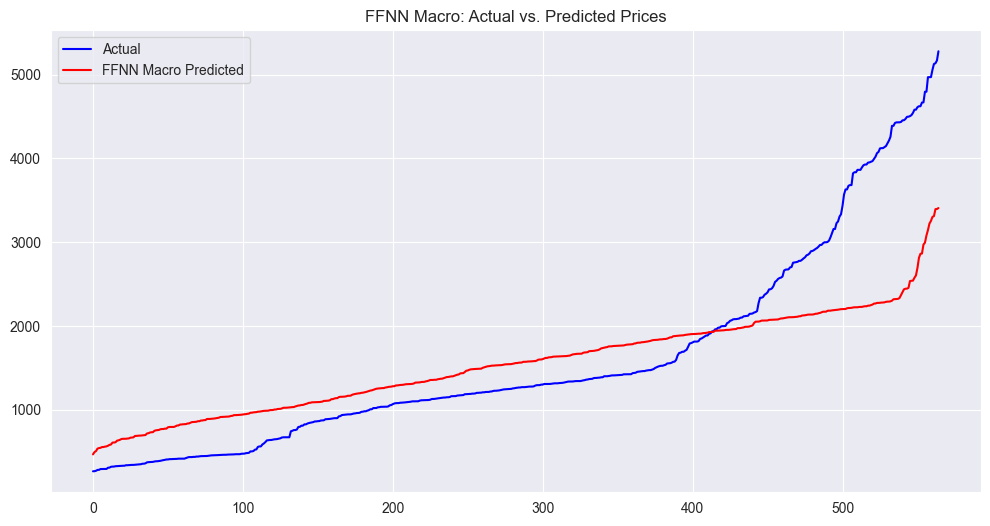

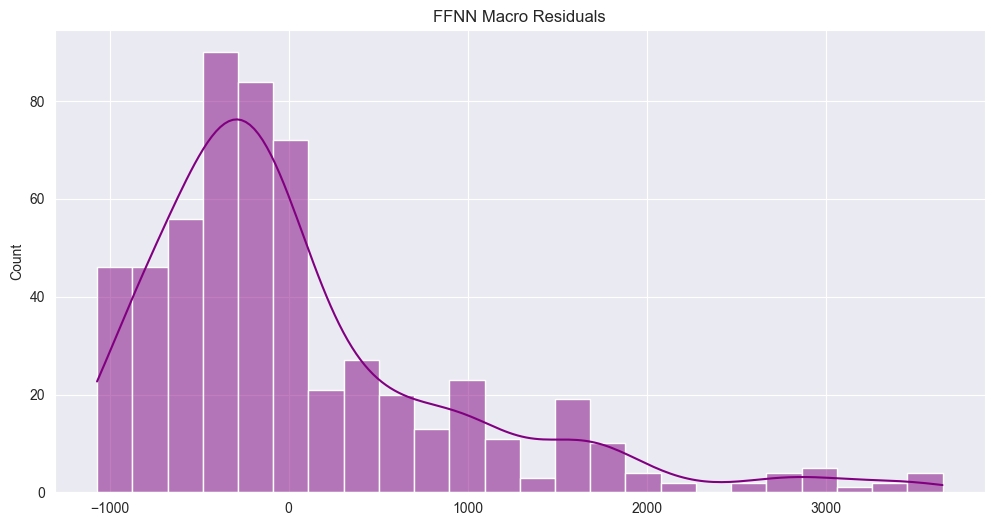

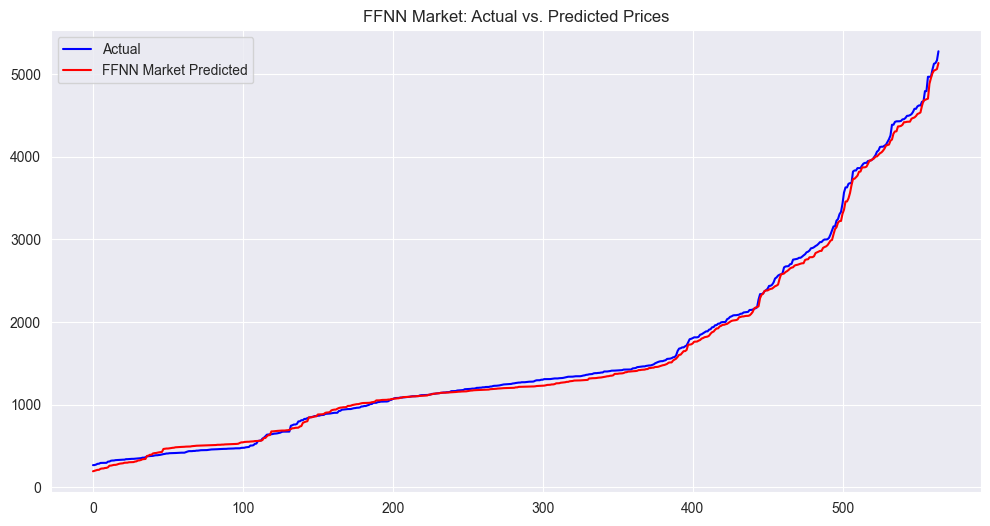

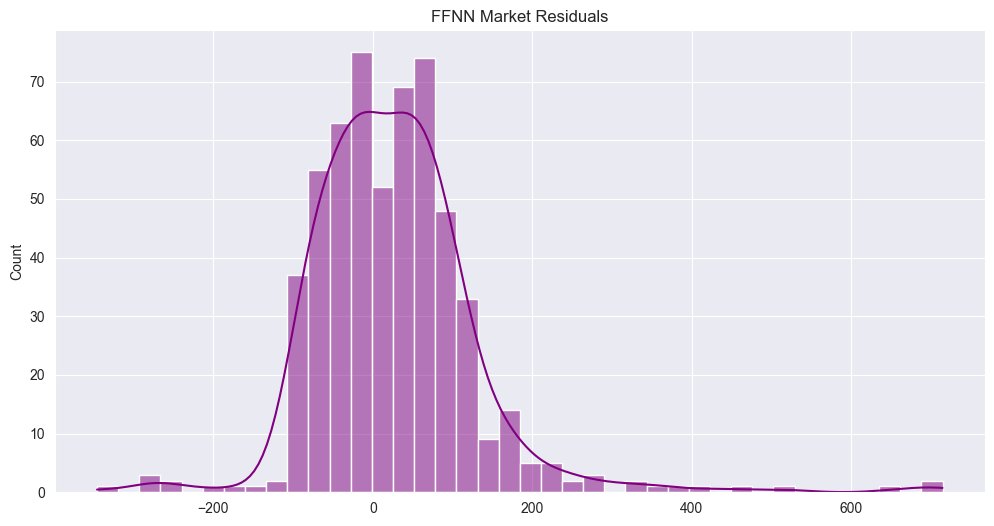

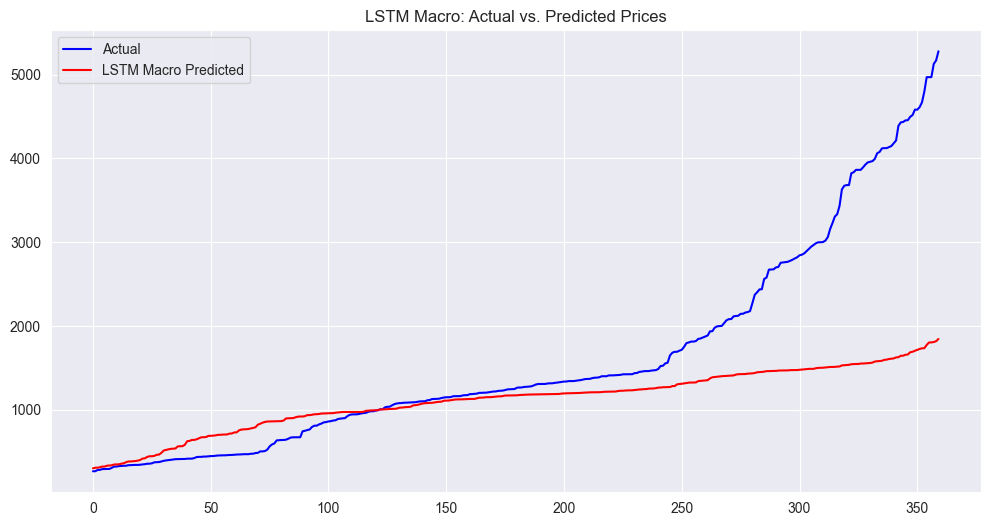

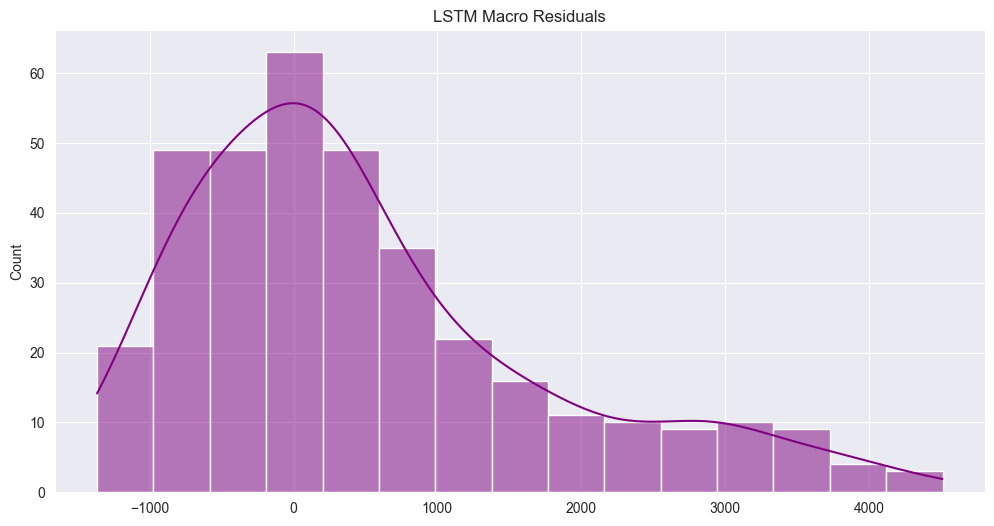

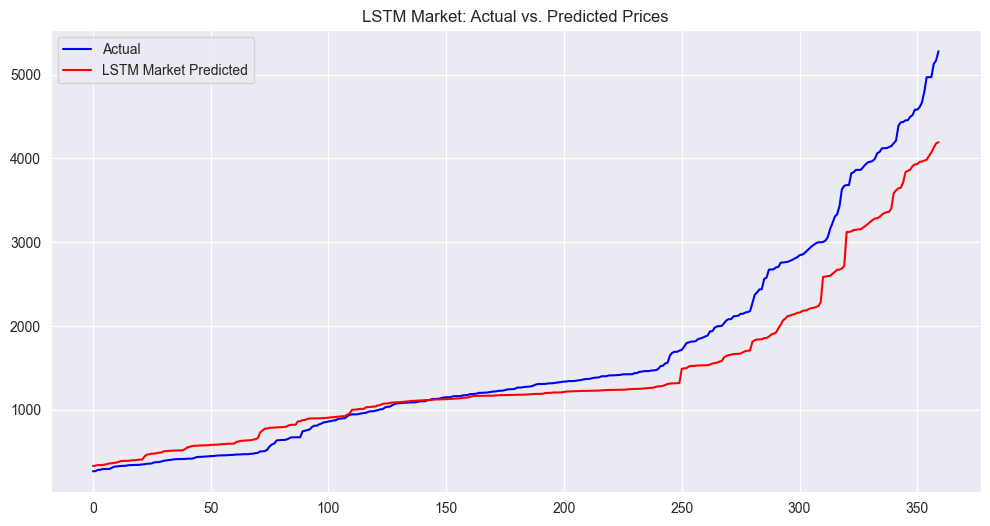

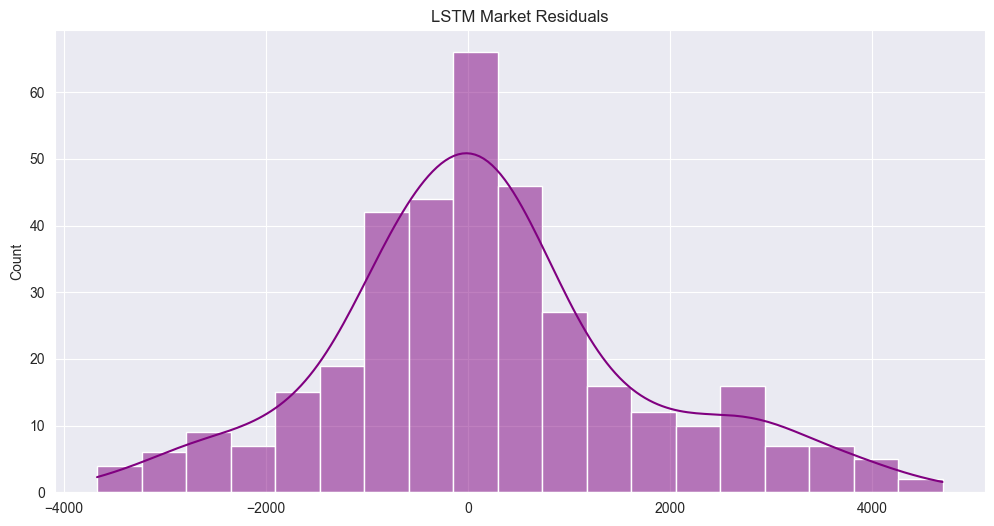

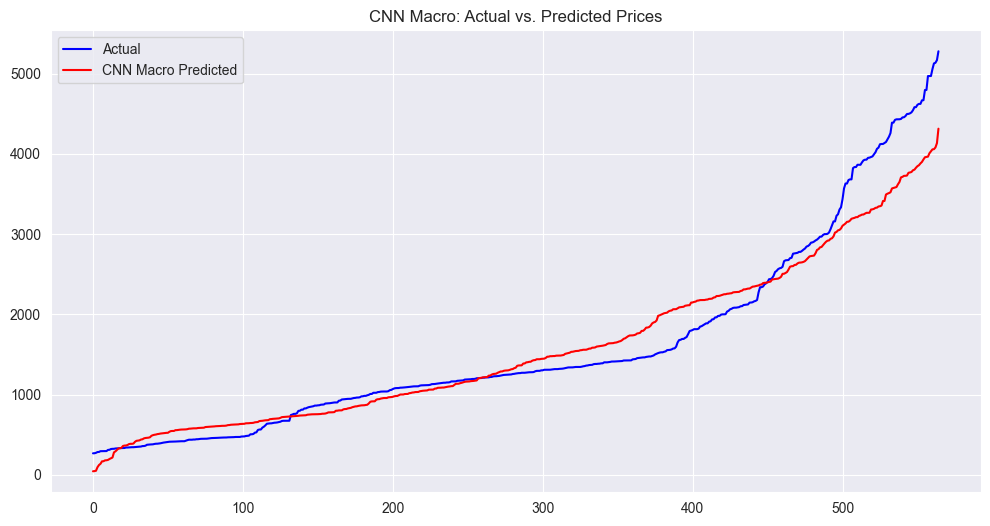

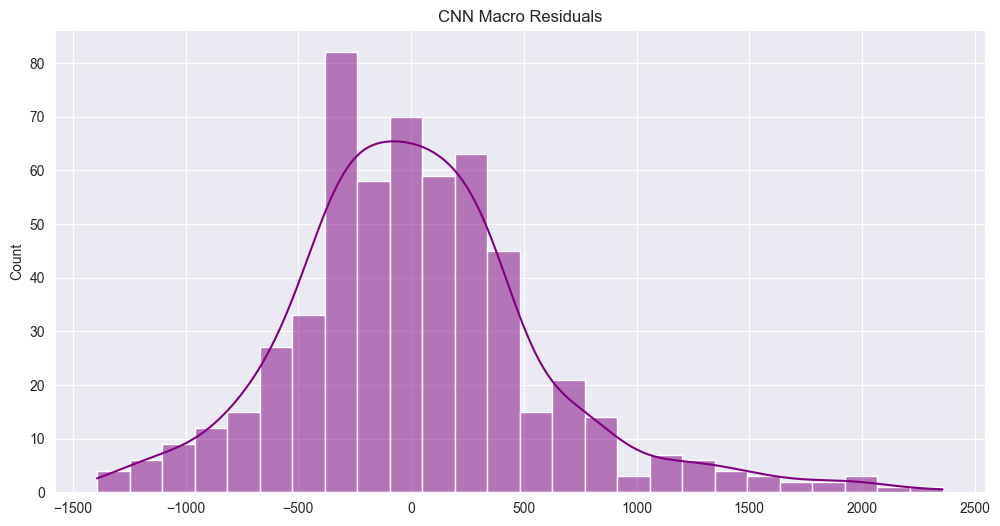

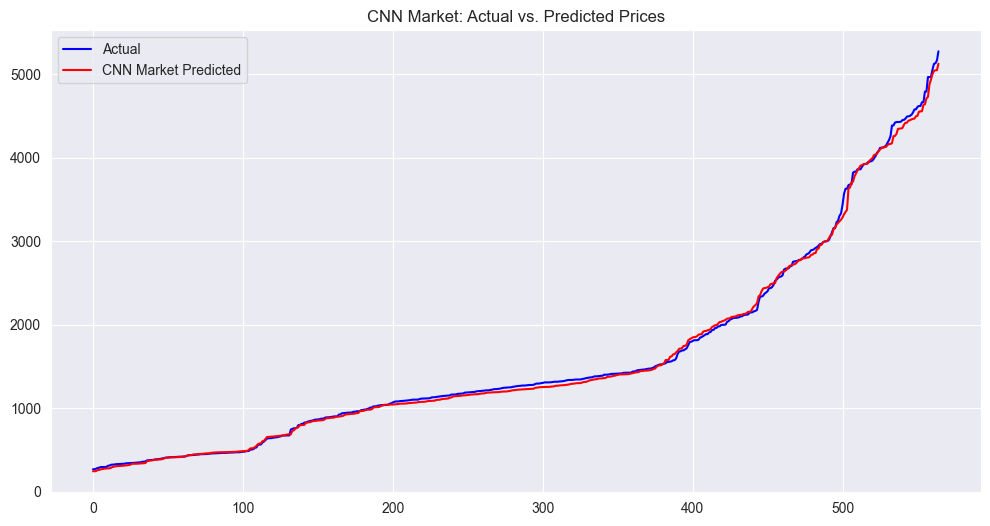

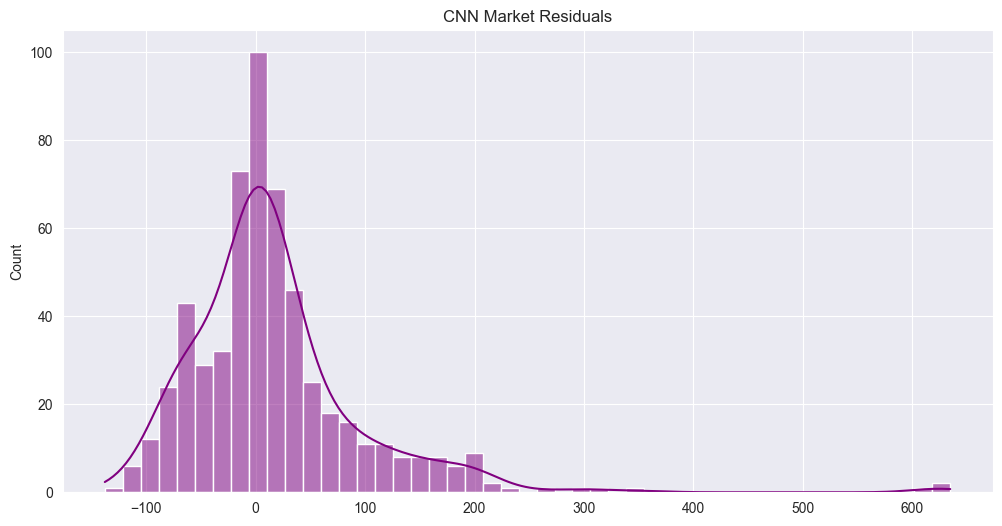

In [205]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display
import pandas as pd

# In sample predictions
ffnn_macro_train_predictions = ffnn_model_macro.predict(X_train_macro)
lstm_macro_train_predictions = lstm_model_macro.predict(X_train_macro_lstm)
cnn_macro_train_predictions = cnn_model_macro.predict(X_train_macro)

ffnn_market_train_predictions = ffnn_model_market.predict(X_train_market)
lstm_market_train_predictions = lstm_model_market.predict(X_train_market_lstm)
cnn_market_train_predictions = cnn_model_market.predict(X_train_market)

# Function to evaluate and compare models
def evaluate_model_performance(model_name, y_train, y_test, train_predictions, test_predictions):
    # Calculate metrics
    in_sample_mse = mean_squared_error(y_train, train_predictions)
    out_sample_mse = mean_squared_error(y_test, test_predictions)
    in_sample_r2 = r2_score(y_train, train_predictions)
    out_sample_r2 = r2_score(y_test, test_predictions)
    
    # Calculate proportion correct and IC
    in_sample_proportion_correct = calculate_proportion_correct(train_predictions, y_train)
    out_sample_proportion_correct = calculate_proportion_correct(test_predictions, y_test)
    in_sample_ic = calculate_ic(in_sample_proportion_correct)
    out_sample_ic = calculate_ic(out_sample_proportion_correct)
    
    return {
        "Model": model_name,
        "In-sample MSE": in_sample_mse,
        "Out-sample MSE": out_sample_mse,
        "In-sample R2": in_sample_r2,
        "Out-sample R2": out_sample_r2,
        "In-sample IC": in_sample_ic,
        "Out-sample IC": out_sample_ic
    }

# Evaluate and compare all models
models_performance = []

# FFNN Macro
models_performance.append(evaluate_model_performance("FFNN Macro", y_train_macro.values, y_test_macro.values, ffnn_macro_train_predictions, ffnn_macro_predictions))

# FFNN Market
models_performance.append(evaluate_model_performance("FFNN Market", y_train_market.values, y_test_market.values, ffnn_market_train_predictions, ffnn_market_predictions))

# LSTM Macro
models_performance.append(evaluate_model_performance("LSTM Macro", y_train_macro_prepared, y_test_macro_prepared, lstm_macro_train_predictions, lstm_macro_predictions))

# LSTM Market
models_performance.append(evaluate_model_performance("LSTM Market", y_train_market_prepared, y_test_market_prepared, lstm_market_train_predictions, lstm_market_predictions))

# CNN Macro
models_performance.append(evaluate_model_performance("CNN Macro", y_train_macro.values, y_test_macro.values, cnn_macro_train_predictions, cnn_macro_predictions))

# CNN Market
models_performance.append(evaluate_model_performance("CNN Market", y_train_market.values, y_test_market.values, cnn_market_train_predictions, cnn_market_predictions))

# Convert to DataFrame for easy visualization
performance_df = pd.DataFrame(models_performance)
display(performance_df)

# Function to plot Actual vs. Predicted and Residuals
def plot_actual_vs_predicted_and_residuals(model_name, y_test, predictions):
    min_length = min(len(y_test), len(predictions))
    y_test = y_test[:min_length]
    predictions = predictions[:min_length]

    plt.figure(figsize=(12, 6))
    plt.plot(sorted(y_test), label='Actual', color='blue')
    plt.plot(sorted(predictions.flatten()), label=model_name + ' Predicted', color='red')
    plt.title(f'{model_name}: Actual vs. Predicted Prices')
    plt.legend()
    plt.show()

    residuals = y_test.flatten() - predictions.flatten()
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True, color='purple')
    plt.title(f'{model_name} Residuals')
    plt.show()

# Plot for each model
for model in models_performance:
    model_name = model["Model"]
    if "Macro" in model_name:
        y_test = y_test_macro.values
        predictions = cnn_macro_predictions if model_name == "CNN Macro" else lstm_macro_predictions if model_name == "LSTM Macro" else ffnn_macro_predictions
    else:
        y_test = y_test_market.values
        predictions = cnn_market_predictions if model_name == "CNN Market" else lstm_market_predictions if model_name == "LSTM Market" else ffnn_market_predictions

    plot_actual_vs_predicted_and_residuals(model_name, y_test, predictions)


## Evaluation
Best Models: FFNN Market and CNN Market show the best overall performance.
Moderate Models: CNN Macro and FFNN Macro have moderate performance with better directional accuracy (IC).
Poor Model: LSTM Macro performs poorly with negative R² and low IC.

### Summary
Calculated Model Accuracy: We used MSE and R-squared to evaluate model performance.
Visualized Results: Plotted actual vs. predicted values for both in-sample and out-of-sample data.
Used Multiple Signal Sets: Evaluated models with macroeconomic and market/technical signals, providing economic motivation.
Analyzed Hypotheses: Formulated and tested hypotheses based on signal sets and discussed the results.
This comprehensive approach ensures we have a detailed analysis and understanding of the performance of our trading algorithm. If you need any further details or additional steps, please let me know!